# Race Recognition using Artificial Neural Networks in Python (Keras)

In this project, we want to classify images with the help of Tensorflow library and Keras interface. For this, we import some libraries into the workspace and decompress the data.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report
import os
import re

# Preprocessing

In [ ]:
!tar -xvf  '/content/drive/MyDrive/UTKFace.tar.gz' -C '/content/'

After decompressing the image dataset, we examine them and remove distorted images. This is one of the common tasks for image dataset preprocessing. There was no image distortion in this dataset. Therefore, no images were deleted.

In [ ]:
folder_path = '/content/UTKFace'
num_skipped = 0
for fname in os.listdir(folder_path):
  fpath = os.path.join(folder_path, fname)
  try:
    fobj = open(fpath, "rb")
    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
  finally:
    fobj.close()
  if not is_jfif:
    num_skipped += 1
    os.remove(fpath)
print(f"Deleted {num_skipped} images")

Deleted 0 images


In this step, we divide the images into 5 classes from zero to four. We do this so that we can use the Keras interface to make the images black and white and resize them to the specified size, i.e. 100x100, when they are loaded. The method used from the Keras interface takes the address of the folder and considers the folders inside it as classes. Therefore, according to the name of each image, we put it in one of the folders zero to four.

In [ ]:
for i in range(5):
  fpath = os.path.join(folder_path, str(i))
  os.makedirs(fpath)
prog = re.compile('_(\d)')
for fname in os.listdir(folder_path):
  imgpath = os.path.join(folder_path, fname)
  if os.path.isfile(imgpath):
    result = prog.findall(fname)
    fpath = os.path.join(folder_path, result[1])
    new_imgpath = os.path.join(fpath, fname)
    os.rename(imgpath, new_imgpath)

Now that we have placed the images in the mentioned folders, we must create the training and test dataset in the ratio of 7:3 from the images and consider the size of the images as 100x100 and remove their color channel.

In [ ]:
train_ds = keras.preprocessing.image_dataset_from_directory(
  folder_path, labels='inferred', label_mode='categorical',
  color_mode='grayscale', batch_size=32, image_size=(100, 100),
  shuffle=True, seed=1400, validation_split=0.3, subset='training'
)
test_ds = keras.preprocessing.image_dataset_from_directory(
  folder_path, labels='inferred', label_mode='categorical',
  color_mode='grayscale', batch_size=32, image_size=(100, 100),
  shuffle=True, seed=1400, validation_split=0.3, subset='validation'
)

Found 23708 files belonging to 5 classes.
Using 16596 files for training.
Found 23708 files belonging to 5 classes.
Using 7112 files for validation.


In this step, we put the training images in the x_train variable and their one-hot encoded label in the y_train variable. We get the number of images of each class and draw their bar chart. It should be noted that if the class of images was not encoded in the form of one-hot, the model might be mistaken in the concept of consecutive numbers and think that the class with a larger number is more valuable than the class with a smaller number, while this is not the case. The use of numerical labels to specify classes is used in problems where the difference between the labels of each class is meaningful. For example, in weight or height classification problems, where order is important, we use labeling.

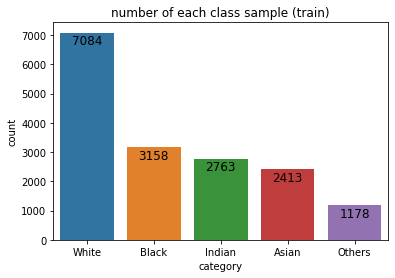

In [ ]:
first_batch = True
for batch in train_ds:
  if first_batch:
    x_train = batch[0].numpy()
    y_train = batch[1].numpy()
    first_batch = False
  else:
    x_train = np.concatenate((x_train, batch[0].numpy()))
    y_train = np.concatenate((y_train, batch[1].numpy()))
(unique, counts) = np.unique(y_train, return_counts=True, axis=0)
unique = list(map(lambda x: np.argmax(x), unique))
counts = list(map(lambda x: x, counts))
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
categories = list(map(lambda x: categories[x], unique))
df = pd.DataFrame({'category': categories,
                   'count': counts})
barplot = sns.barplot(x='category',
                      y='count',
                      data=df,
                      order=df.sort_values('count', ascending=False).category)
title = plt.title('number of each class sample (train)')
for p in barplot.patches:
  barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=12,
                   xytext=(0, -8),
                   textcoords='offset points')

We do the abovementioned process for the test data, too.

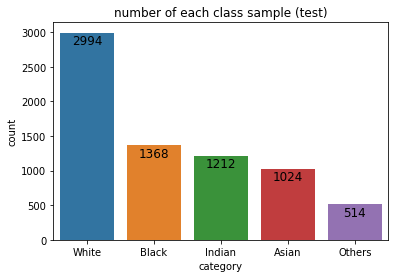

In [ ]:
first_batch = True
for batch in test_ds:
  if first_batch:
    x_test = batch[0].numpy()
    y_test = batch[1].numpy()
    first_batch = False
  else:
    x_test = np.concatenate((x_test, batch[0].numpy()))
    y_test = np.concatenate((y_test, batch[1].numpy()))
(unique, counts) = np.unique(y_test, return_counts=True, axis=0)
unique = list(map(lambda x: np.argmax(x), unique))
counts = list(map(lambda x: x, counts))
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
categories = list(map(lambda x: categories[x], unique))
df = pd.DataFrame({'category': categories,
                   'count': counts})
barplot = sns.barplot(x='category',
                      y='count',
                      data=df,
                      order=df.sort_values('count', ascending=False).category)
title = plt.title('number of each class sample (test)')
for p in barplot.patches:
  barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center',
                   size=12,
                   xytext=(0, -8),
                   textcoords = 'offset points')

It can be seen that the number of dataset images for "White" class is more than other images. Also, the "Others" class has the least number of images.

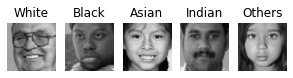

In [ ]:
categories = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}
plt.figure(figsize=(5, 5))
j = 0
for image, label in zip(x_train, y_train):
  label = np.argmax(label)
  if label == j:
    ax = plt.subplot(1, 5, j + 1)
    plt.imshow(image.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label])
    plt.axis("off")
    j += 1
  elif j > 4:
    break

As can be seen, 5 sample images are plotted to show what type of images each class has. At this point, we need to normalize the images. This is done to train the model properly. For this purpose, we divide all matrix elements by 255. Plus, we convert each image from 2-D to 1-D.

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 100 * 100 * 1))
x_test = x_test.reshape((x_test.shape[0], 100 * 100 * 1))
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Training

In this step, we design a four-layer network with two middle layers. The number of input neurons is 10,000 and the number of output neurons is 5. The activation function of all layers except the last layer, which is Softmax, is ReLU, and the number of neurons in the middle layers is 32 and 1024, respectively. We consider the optimizer as Stochastic Gradient Descent (SGD) and the learning rate is equal to 0.01. We also put the loss function as the Categorical Cross-entropy, which is explained below.<br>

By considering the loss-epoch graph of the training data, we can see that the loss has decreased with a slight slope, however, in the loss-epoch diagram of the test data, the loss has fluctuated and has noise. To solve this problem, the model can be regularized. The methods of model regularization include increasing the number of training data (or generating artificial data), improving the data normalization method, reducing the learning rate (because if the learning rate is large, the optimizer will cross the local minimum and cannot find it), increase The learning rate (when the learning rate is too small, noise is created on the loss-epoch graph), the use of other optimizer functions such as Adam or regularization layers such as L-2 and dropout, or early stopping methods.

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_139 (Dense)            (None, 32)                320032    
_________________________________________________________________
dense_140 (Dense)            (None, 1024)              33792     
_________________________________________________________________
dense_141 (Dense)            (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.72      0.87      0.79      7084
       Black       0.70      0.85      0.77      3158
       Asian       0.78      0.65      0.71      2413
      Indian       0.70      0.53      0.61      2763
      Others       0.42      0.02      0.04      1178

    accuracy                           0.72     165

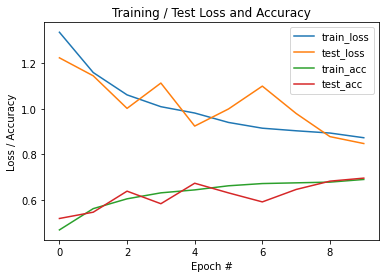

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

As can be seen, the "precision" value for the first 4 classes is almost the same for the test and training data. However, the "precision" value of the "Others" class on the training data is 42% and on the test data is 37%. The "macro average" of "precision" values is 66% for the training data and 64% for the test data.<br>
Regarding the "recall" values, it can be said that the performance of the model was acceptable for recognizing the "White", "Black", "Asian" and "Indian" classes, however, almost none of the images could be correctly placed in the "Others" class. The reason for this could be the small number of training data for this class. One way to solve the problem is to scale the training data. It means equalizing the number of data in each class. For this, some synthetic data can be generated using the existing data for the "Others" class. It is expected that with this work, the recognition power of the model for this class will increase.

# Exp 1: Testing Different Optimizers

In this experiment, we want to know the effect of the optimizer function on the model's training process. For this purpose, we explain the concept of "Momentum". We know that normally, the optimizer subtracts the product of the learning rate and the derivative of the loss function with respect to the weight, from the previous weight and sets it equal to the new weight at each step of batch training. If we want to use "Momentum", the update equation will be
<br><br>
**velocity = momentum * velocity - learning_rate * g**
<br>
**w = w + velocity**
<br><br>
in which, "velocity" is equal to the weight changes in the previous stage and "g" is the derivative of the loss function with respect to the weight. It is clear that if the "momentum" is zero, the normal update equation is obtained. The closer the "momentum" is to 1, the more the update pattern of the previous step will be followed, and the closer to zero, the less. If the changes are in the same direction, an "acceleration effect" occurs. It means that learning is accelerated. Otherwise, the "stability effect" appears and causes the weight to not change much. For this reason, one of the ways to eliminate jumps in the loss-epoch graph on the test data is to use "momentum". It should be noted that with the increase in the number of iterations, the effect of the "momentum" will decrease and in this way, we will be less away from the optimal value for the weight.

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.79      0.77      0.78      7084
       Black       0.66      0.87      0.75      3158
       Asian       0.70      0.78      0.73      2413
      Indian       0.64      0.62      0.63      2763
      Others       0.40      0.04      0.08      1178

    accuracy                           0.72     165

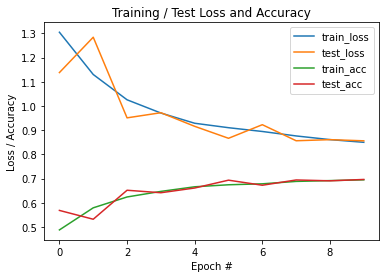

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01, 0.5), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

It can be seen that considering the "momentum" equal to 0.5, the accuracy of the model did not increase much, however, it is clear that the loss-epoch graph of the test data has fewer jumps. That is, by increasing the number of epochs, the use of "momentum" provides the possibility of achieving better accuracy. Regarding the number of parameters of the model, we can say that since the input vector of the model has 10,000 elements and the number of neurons in the first hidden layer is 32, we will have 320032 parameters by considering the 32 bias values. Also, 32 x 1024 plus 1024 equals 33792, which represents the number of parameters for the next layer. The number of parameters of the last layer is equal to the product of 5 x 1024 plus 5. So, in total, we will have 358949 parameters for training.

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_39 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       White       0.43      1.00      0.60      7084
       Black       0.00      0.00      0.00      3158
       Asian       0.00      0.00      0.00      2413
      Indian       0.00      0.00      0.00      2763
      Others       0.00      0.00      0.00      1178

    accuracy                           0.43     16596
   macro avg       0.09      0.20      0.12     16596
weighted avg       0.18      0.43      0.26     16596

              precision    recall  f1-score   support

       White       0.42      1.00      0.59      2994
       Black       0.00      0.00      0.00      1368
       Asian       0.00      0.00      0.00      1024
      Indian       0.00      0.00      0.00      1212
      Others       0.00      0.00      0.00       514

    accuracy                           0.42      7112
   macro avg       0.08      0.20      0.12      7112
weighted avg       0.18      0.42      0.25      7112



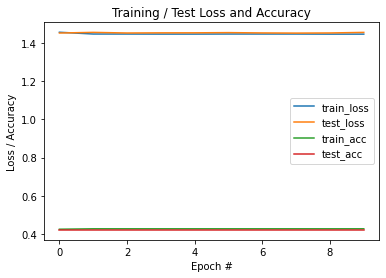

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.01, 0.9), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

It can be seen that considering the "momentum" equal to 0.9, no training was done and the accuracy value did not change. The reason for this is that the model is too influenced by the previous training and no matter how much the gradient of the loss function increases, it cannot overcome the influence of the previous training. Therefore, it is clear that increasing the "momentum" is not always profitable and can disrupt training.

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_44 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_45 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.68      0.90      0.77      7084
       Black       0.81      0.75      0.78      3158
       Asian       0.72      0.72      0.72      2413
      Indian       0.72      0.48      0.57      2763
      Others       0.33      0.00      0.00      1178

    accuracy                           0.71     165

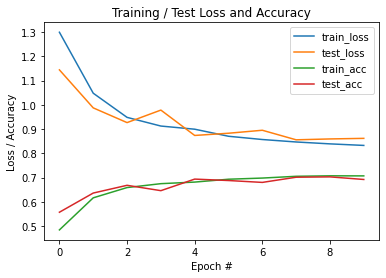

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_48 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       White       0.43      1.00      0.60      7084
       Black       0.00      0.00      0.00      3158
       Asian       0.00      0.00      0.00      2413
      Indian       0.00      0.00      0.00      2763
      Others       0.00      0.00      0.00      1178

    accuracy                           0.43     16596
   macro avg       0.09      0.20      0.12     16596
weighted avg       0.18      0.43      0.26     16596

              precision    recall  f1-score   support

       White       0.42      1.00      0.59      2994
       Black       0.00      0.00      0.00      1368
       Asian       0.00      0.00      0.00      1024
      Indian       0.00      0.00      0.00      1212
      Others       0.00      0.00      0.00       514

    accuracy                           0.42      7112
   macro avg       0.08      0.20      0.12      7112
weighted avg       0.18      0.42      0.25      7112



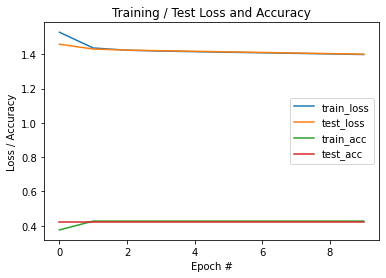

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 10), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 10), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 10), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 10), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

It can be seen that for a learning rate of 0.0001, Adam outperforms SGD. Note that Adam did not perform well with the mentioned learning rate, so it was decided to use this learning rate. It should be noted that the use of Adam's optimizer function also reduced the jumps in the loss-epoch graph of the test data. Also, the use of decreasing gradient and "momentum" has resulted the best so far. Of course, with the increase in the number of epochs, this model will suffer from overfit.

# Exp 2: Testing Different Number of Epochs

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_50 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.71      0.88      0.78      7084
       Black       0.81      0.78      0.80      3158
       Asian       0.90      0.49      0.64      2413
      Indian       0.60      0.74      0.66      2763
      Others       0.51      0.02      0.03      1178

    accuracy                           0.72     165

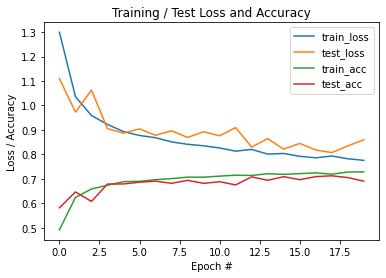

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

It can be seen that the accuracy of the model increased on the test and training data. We know that in order for the model to perform well on the test data class prediction, it must be trained with appropriate weights and biases. For this, it is necessary to regularize it several times with the training data. Usually this process takes more than one time. Because once it is executed, gradient descent cannot find the optimal extremum. Unless the initial weights are randomly optimal, which is unlikely. So, in general, the model must see the training data several times in order to find the power of classification of the data it has not seen. Usually, we do this until the overfit begins. That is, despite the optimization of the model's performance on the training data, the error for the test data increases. Of course, this data is generally called validation data, which in some models can be used to control the number of epochs during training. Therefore, it can be said that increasing the number of epochs is not always useful and can weaken the power of the model. The way that is suggested to prevent the increase of variance and the occurrence of the overfit phenomenon is the same as mentioned earlier, i.e., using the validation data and stopping the training process if after a certain number of epochs, the accuracy of the validation data changes against the accuracy of the training data. Of course, this can also be done by considering a threshold. In such a way that after passing a number of epochs, if the accuracy of the training data does not change more than the specified threshold, the training process will be stopped, because there may be no training from some point, onwards.

# Exp 3: Testing Different Loss Functions

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_65 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_66 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.77      0.83      0.80      7084
       Black       0.73      0.84      0.78      3158
       Asian       0.86      0.65      0.74      2413
      Indian       0.59      0.74      0.66      2763
      Others       0.51      0.04      0.07      1178

    accuracy                           0.73     165

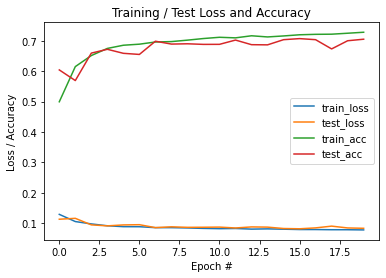

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

As can be seen, using the mentioned cost function for this model improved the performance. Of course, we generally know that this cost function is used in regression problems because the distance between the output values ​​is small and the speed of convergence needs to be slower. If the speed of convergence increases (for example, if we use the cross-entropy cost function), the convergence may not be done and the model may not reach local minima. Cross-entropy cost function is also used for classification problems. Because the slope of the logarithm is steeper and the convergence in these problems (where each sample belongs to the same class) is done faster. Using the mean squared error cost function in these problems is not recommended because it focuses on all model outputs. Now, only the output related to the sample class should be more than the others, and it is not necessary to check the other outputs.<br>
It should be noted that after using the regularization methods on both "mean squared error" and "cross entropy" models, the accuracy of the second model improved. Therefore, in the rest of the work, we use the same previous cost function.

# Exp 4: Testing Different Regularization Methods

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_74 (Dense)             (None, 1024)              33792     
_________________________________________________________________
dense_75 (Dense)             (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.77      0.85      0.81      7084
       Black       0.84      0.78      0.81      3158
       Asian       0.76      0.77      0.76      2413
      Indian       0.67      0.71      0.69      2763
      Others       0.43      0.17      0.24      1178

    accuracy                           0.75     165

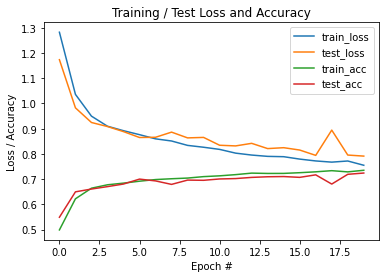

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

As can be seen, the use of the weight squared regulator has made the loss-epoch graph of the test data not have many jumps and has also improved the accuracy. Using this method, i.e. adding a term to the cost function to penalize the parameters, prevents them from accurately modeling the training data and thus generalizes to new examples.

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 32)                320032    
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 1024)              33792     
_________________________________________________________________
dense_159 (Dense)            (None, 5)                 5125      
Total params: 358,949
Trainable params: 358,949
Non-trainable params: 0
_________________________________________________________________
              precision    recall  f1-score   support

       White       0.76      0.84      0.80      7084
       Black       0.77      0.80      0.79      3158
       Asian       0.75      0.74      0.74      2413
      Indian       0.62     

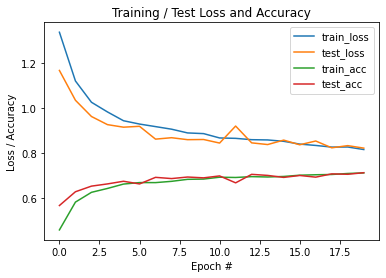

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(10000,), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()
H = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32, verbose=0)
predictions = model.predict(x_train, batch_size=32)
print(classification_report(y_train.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
predictions = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[categories[x] for x in np.arange(0, 5)]))
plt.figure()
plt.plot(np.arange(0, 20), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, 20), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, 20), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, 20), H.history['val_accuracy'], label='test_acc')
plt.title("Training / Test Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / Accuracy")
legend = plt.legend()

Dropout is one of the regulation methods, the use of which reduces the possibility of overfit. However, it may lead to an increase in variance in some cases. For example, using it just before the last layer makes the model unable to remove the error created by the dropout layer, and as a result, the learning may not be done correctly. If the model is simple compared to the dataset, regularization may not be necessary. Because the capacity of the model is already low and reducing it will weaken the performance. Finally, if training elapsed time is short, dropout is counterproductive, because it has been observed that the dropout at the beginning of the training causes the accuracy to decrease and when it converges to the final accuracy, it improves the performance. In this model, it can be seen that the use of regularization methods, as mentioned earlier, has softened the loss-epoch graph of the test data and improved the accuracy of the model on the test data.

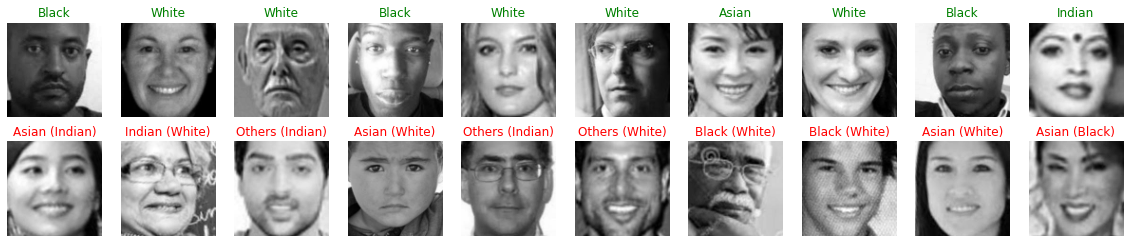

In [ ]:
x_test = x_test.astype('float32') * 255.0
plt.figure(figsize=(20, 4))
correct_pred = 0
wrong_pred = 0
for x, y, y_pred in zip(x_test, y_test, predictions):
  label = np.argmax(y)
  if correct_pred != 10 and label == np.argmax(y_pred):
    ax = plt.subplot(2, 10, correct_pred + 1)
    plt.imshow(x.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label], c='g')
    plt.axis("off")
    correct_pred += 1
  elif correct_pred == 10 and  wrong_pred != 10 and label != np.argmax(y_pred):
    ax = plt.subplot(2, 10, wrong_pred + 11)
    plt.imshow(x.reshape(100, 100).astype("uint8"), cmap='gray')
    plt.title(categories[label] + ' (' + categories[np.argmax(y_pred)] + ')', c='r')
    plt.axis("off")
    wrong_pred += 1
  elif correct_pred == 10 and wrong_pred == 10:
    break